In [2]:
import warnings
import pathlib
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


warnings.filterwarnings('ignore')
%matplotlib inline

print("PROJECT_DIR", PROJECT_DIR := pathlib.Path.cwd())
print("DATA_DIR", DATA_DIR := PROJECT_DIR / "data")


/home/uzunb/Projects/municipality-bus-utilization-forecasting/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PROJECT_DIR /home/uzunb/Projects/municipality-bus-utilization-forecasting
DATA_DIR /home/uzunb/Projects/municipality-bus-utilization-forecasting/data


In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    """  Mean Absolute Percentage Error - MAPE """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
# Read the data
df = pd.read_csv(DATA_DIR / 'municipality_bus_utilization.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('timestamp')
df

,municipality_id,usage,total_capacity
timestamp,,,
2017-06-04 07:59:42,9,454,1332
2017-06-04 07:59:42,8,556,2947
2017-06-04 07:59:42,4,1090,3893
2017-06-04 07:59:42,0,204,2813
2017-06-04 07:59:42,7,718,2019
...,...,...,...
2017-08-19 16:30:35,2,548,697
2017-08-19 16:30:35,8,1193,2947
2017-08-19 16:30:35,7,1354,2019


In [5]:
# split timestamp to year, month, day and hour, minute, second
df['date'] = pd.to_datetime(df.index.date)
df['time'] = df.index.time
df['year'] = df.index.year
df['month'] = df.index.month
df['dayOfWeek'] = df.index.dayofweek
df['day'] = df.index.day
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['second'] = df.index.second
df['quarter'] = df.index.quarter
df['dayOfYear'] = df.index.dayofyear

df.head()

,municipality_id,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear
timestamp,,,,,,,,,,,,,,
2017-06-04 07:59:42,9,454,1332,2017-06-04,07:59:42,2017,6,6,4,7,59,42,2,155
2017-06-04 07:59:42,8,556,2947,2017-06-04,07:59:42,2017,6,6,4,7,59,42,2,155
2017-06-04 07:59:42,4,1090,3893,2017-06-04,07:59:42,2017,6,6,4,7,59,42,2,155
2017-06-04 07:59:42,0,204,2813,2017-06-04,07:59:42,2017,6,6,4,7,59,42,2,155
2017-06-04 07:59:42,7,718,2019,2017-06-04,07:59:42,2017,6,6,4,7,59,42,2,155


In [6]:
df['usage_percentage'] = df['usage']/df['total_capacity']*100
df.sort_values(by='usage_percentage', ascending=False).head()

,municipality_id,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage
timestamp,,,,,,,,,,,,,,,
2017-08-16 12:56:12,1,412,397,2017-08-16,12:56:12,2017,8,2,16,12,56,12,3,228,103.778338
2017-08-10 12:55:40,1,412,397,2017-08-10,12:55:40,2017,8,3,10,12,55,40,3,222,103.778338
2017-08-11 13:59:44,1,412,397,2017-08-11,13:59:44,2017,8,4,11,13,59,44,3,223,103.778338
2017-08-10 16:25:40,1,412,397,2017-08-10,16:25:40,2017,8,3,10,16,25,40,3,222,103.778338
2017-08-18 12:03:23,1,412,397,2017-08-18,12:03:23,2017,8,4,18,12,3,23,3,230,103.778338


In [7]:
# edit usage data for total capacity
df['usage'] = df.apply(lambda x: x['total_capacity'] if x['usage'] > x['total_capacity'] else x['usage'], axis=1)
df['usage_percentage'] = df['usage']/df['total_capacity']*100
df.sort_values(by='usage_percentage', ascending=False).head()

,municipality_id,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage
timestamp,,,,,,,,,,,,,,,
2017-08-12 15:29:47,1,397,397,2017-08-12,15:29:47,2017,8,5,12,15,29,47,3,224,100.0
2017-08-08 12:59:24,1,397,397,2017-08-08,12:59:24,2017,8,1,8,12,59,24,3,220,100.0
2017-08-11 13:05:46,1,397,397,2017-08-11,13:05:46,2017,8,4,11,13,5,46,3,223,100.0
2017-07-26 16:01:04,1,397,397,2017-07-26,16:01:04,2017,7,2,26,16,1,4,3,207,100.0
2017-07-19 14:04:17,1,397,397,2017-07-19,14:04:17,2017,7,2,19,14,4,17,3,200,100.0


In [8]:
# Check missing values. due to 'There are 10 municipalities (ids from 0 to 9), and two measurements for an hour.'

check_df = df[['municipality_id', 'date', 'hour']].groupby(['municipality_id', 'date', 'hour']).size().reset_index(name='counts')
print("Count of one measurement for an hour", check_df[check_df['counts'] == 1].shape[0])
print("Count of two measurements for an hour", check_df[check_df['counts'] == 2].shape[0])
print("Count of more than two measurements for an hour", check_df[check_df['counts'] > 2].shape[0])
check_df.sort_values('counts', ascending=True)

Count of one measurement for an hour 1360
Count of two measurements for an hour 4510
Count of more than two measurements for an hour 870


,municipality_id,date,hour,counts
0,0,2017-06-04,7,1
1889,2,2017-08-06,7,1
5005,7,2017-07-06,12,1
5007,7,2017-07-06,14,1
5009,7,2017-07-06,16,1
...,...,...,...,...
5625,8,2017-06-30,13,6
2255,3,2017-06-30,13,6
1581,2,2017-06-30,13,6
4277,6,2017-06-30,13,6


In [9]:
# create new timestamp for one measurement for an hour
from datetime import datetime


new_timestamps = pd.DataFrame(columns=['timestamp', 'municipality_id', 'usage',
                              'total_capacity', 'date', 'time', 'year', 'month', 'dayOfWeek', 'day', 'hour'])
for municipality_id in df['municipality_id'].unique():
    for date in df['date'].unique():
        for hour in df['hour'].unique():
            if check_df[(check_df['municipality_id'] == municipality_id) & (check_df['date'] == date) & (check_df['hour'] == hour)]['counts'].values == 1:
                new_record = {'timestamp': f"{date} {hour}:00:00", 'municipality_id': municipality_id, 'usage': np.nan, 'total_capacity': np.nan,
                              'date': date, 'time': datetime.strptime(f"{hour}:00:00", '%H:%M:%S').time(), 'year': date.year, 'month': date.month, 'dayOfWeek': date.dayofweek, 'day': date.day, 'hour': hour,
                              'minute': 0, 'second': 0, 'quarter': date.quarter, 'dayOfYear': date.dayofyear, 'usage_percentage': np.nan}
                new_timestamps = pd.concat(
                    [new_timestamps, pd.DataFrame.from_records([new_record])])

# add new timestamp to df
expanded_df = df.copy()
expanded_df = expanded_df.reset_index()
expanded_df = pd.concat([expanded_df, new_timestamps], ignore_index=True)
expanded_df['timestamp'] = pd.to_datetime(expanded_df['timestamp'])
expanded_df = expanded_df.set_index('timestamp')
expanded_df.sort_index(inplace=True)
expanded_df


,municipality_id,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage
timestamp,,,,,,,,,,,,,,,
2017-06-04 07:00:00,9,NaN,NaN,2017-06-04,07:00:00,2017,6,6,4,7,0.0,0.0,2.0,155.0,NaN
2017-06-04 07:00:00,8,NaN,NaN,2017-06-04,07:00:00,2017,6,6,4,7,0.0,0.0,2.0,155.0,NaN
2017-06-04 07:00:00,4,NaN,NaN,2017-06-04,07:00:00,2017,6,6,4,7,0.0,0.0,2.0,155.0,NaN
2017-06-04 07:00:00,0,NaN,NaN,2017-06-04,07:00:00,2017,6,6,4,7,0.0,0.0,2.0,155.0,NaN
2017-06-04 07:00:00,7,NaN,NaN,2017-06-04,07:00:00,2017,6,6,4,7,0.0,0.0,2.0,155.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-19 16:30:35,5,202,587,2017-08-19,16:30:35,2017,8,5,19,16,30.0,35.0,3.0,231.0,34.412266
2017-08-19 16:30:35,9,815,1332,2017-08-19,16:30:35,2017,8,5,19,16,30.0,35.0,3.0,231.0,61.186186
2017-08-19 16:30:35,0,1271,2813,2017-08-19,16:30:35,2017,8,5,19,16,30.0,35.0,3.0,231.0,45.183079


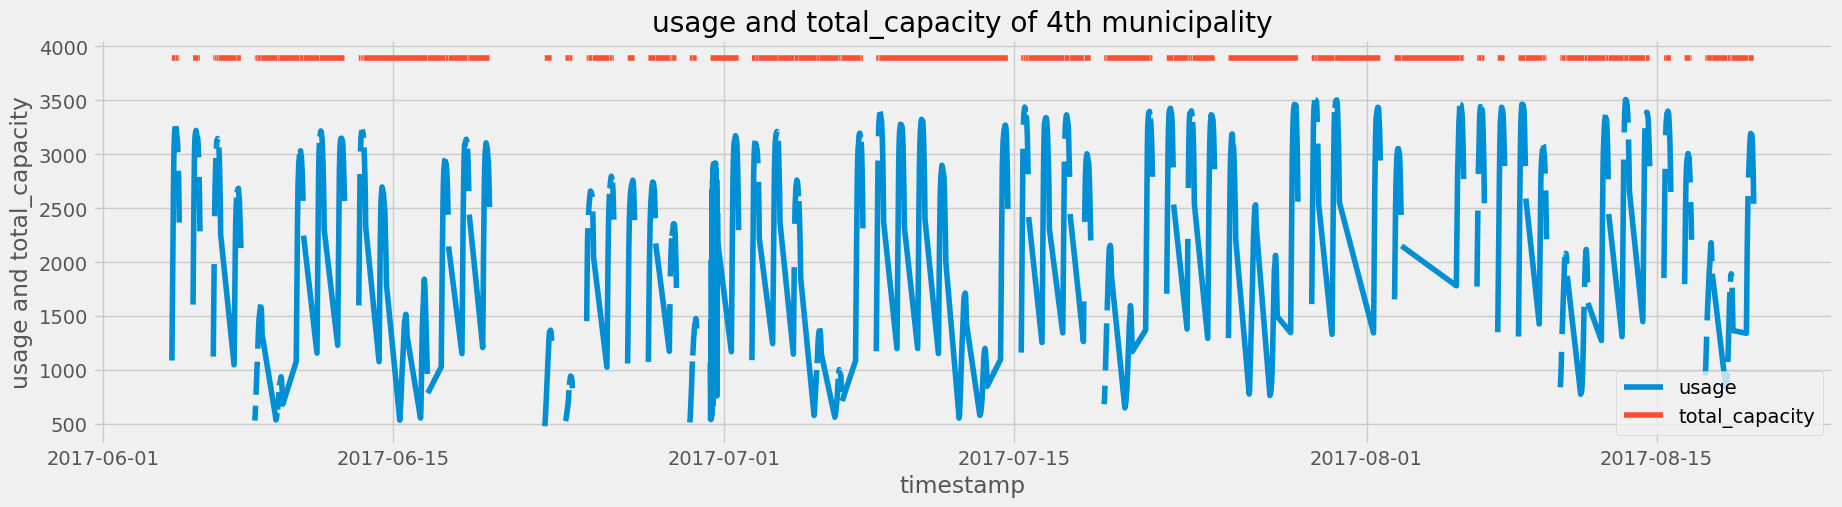

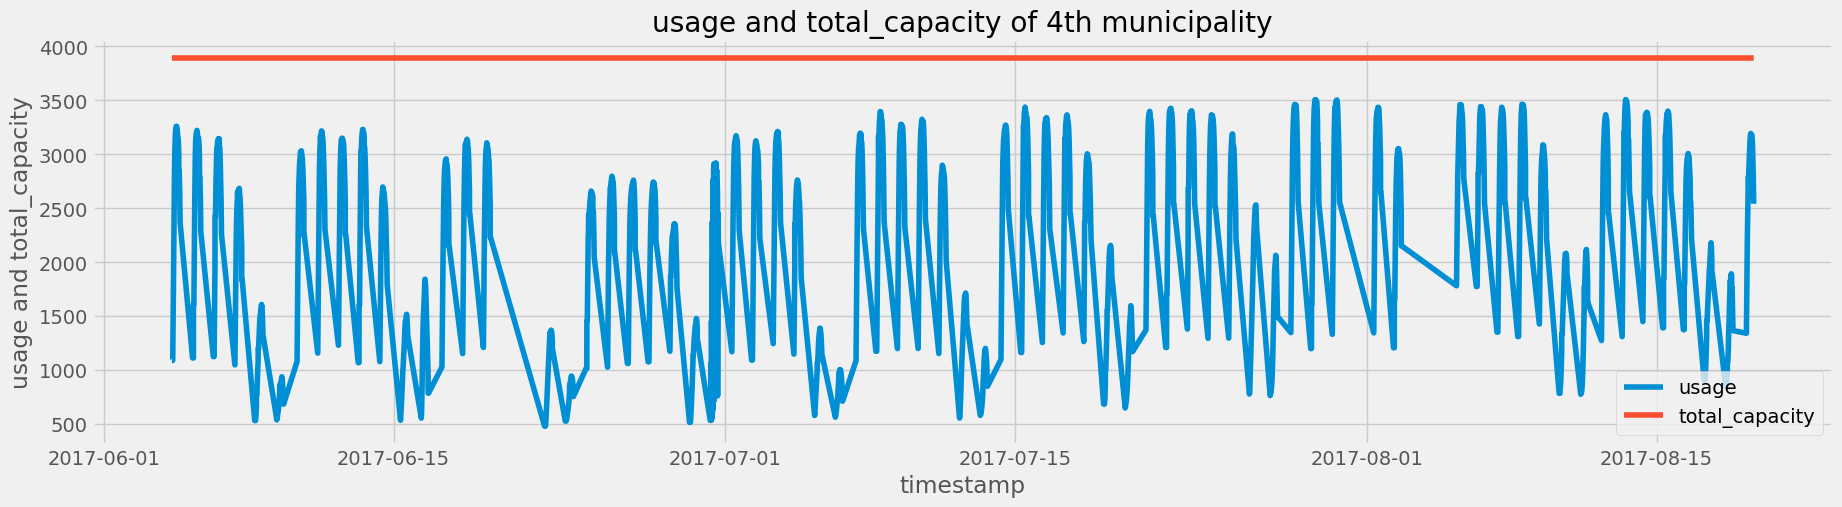

In [10]:
selected_municipality_id = 4

# plot usage and show missing values in 4th municipality
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(expanded_df[expanded_df['municipality_id'] == selected_municipality_id]['usage'], label='usage')
ax.plot(expanded_df[expanded_df['municipality_id'] == selected_municipality_id]['total_capacity'], label='total_capacity')
ax.legend()
ax.set_title('usage and total_capacity of 4th municipality')
ax.set_xlabel('timestamp')
ax.set_ylabel('usage and total_capacity')
plt.show()

# impute missing values for each municipality
imputed_df = expanded_df.copy()
for municipality_id in imputed_df['municipality_id'].unique():
    # fill total_capacity with max value
    imputed_df.loc[imputed_df['municipality_id'] == municipality_id, 'total_capacity'] = imputed_df[imputed_df['municipality_id'] == municipality_id]['total_capacity'].fillna(imputed_df[imputed_df['municipality_id'] == municipality_id]['total_capacity'].max())

    # fill usage with interpolation that is best appropriate of method
    imputed_df.loc[imputed_df['municipality_id'] == municipality_id, 'usage'] = imputed_df[imputed_df['municipality_id'] == municipality_id]['usage'].fillna(method='bfill')
    imputed_df.loc[imputed_df['municipality_id'] == municipality_id, 'usage'] = imputed_df[imputed_df['municipality_id'] == municipality_id]['usage'].fillna(method='ffill')

imputed_df['usage_percentage'] = imputed_df['usage']/imputed_df['total_capacity']*100

# plot usage and show missing values in 4th municipality
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(imputed_df[imputed_df['municipality_id'] == selected_municipality_id]['usage'], label='usage')
ax.plot(imputed_df[imputed_df['municipality_id'] == selected_municipality_id]['total_capacity'], label='total_capacity')
ax.legend()
ax.set_title('usage and total_capacity of 4th municipality')
ax.set_xlabel('timestamp')
ax.set_ylabel('usage and total_capacity')
plt.show()



In [11]:
df = imputed_df.copy()

# Preprocessing

In [12]:
FEATURES = df.drop(columns=['usage', 'municipality_id', 'time']).columns
TARGET = 'usage'
selected_municipality_id = 4

thMunicipalityDf = df[df['municipality_id'] == selected_municipality_id]
thMunicipalityDf = thMunicipalityDf.drop(columns=['municipality_id'])

# split data to train and test set
horizon = pd.to_datetime("2017-08-05")

train = thMunicipalityDf[thMunicipalityDf.date < horizon]
test = thMunicipalityDf[thMunicipalityDf.date >= horizon]

print(f"Shape of Dataframe: {df.shape}")
print(f"Shape of Train Set: {train.shape}")
print(f"Shape of Test Set: {test.shape}")

Shape of Dataframe: (14430, 15)
Shape of Train Set: (1138, 14)
Shape of Test Set: (305, 14)


# Model Development

## Forecasting with Prophet

In [13]:
train.info()
display(train.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1138 entries, 2017-06-04 07:00:00 to 2017-08-02 16:32:54
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   usage             1138 non-null   object        
 1   total_capacity    1138 non-null   object        
 2   date              1138 non-null   datetime64[ns]
 3   time              1138 non-null   object        
 4   year              1138 non-null   object        
 5   month             1138 non-null   object        
 6   dayOfWeek         1138 non-null   object        
 7   day               1138 non-null   object        
 8   hour              1138 non-null   object        
 9   minute            1138 non-null   float64       
 10  second            1138 non-null   float64       
 11  quarter           1138 non-null   float64       
 12  dayOfYear         1138 non-null   float64       
 13  usage_percentage  1138 non-null   object  

,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage
timestamp,,,,,,,,,,,,,,
2017-06-04 07:00:00,1090,3893,2017-06-04,07:00:00,2017,6,6,4,7,0.0,0.0,2.0,155.0,27.998973
2017-06-04 07:59:42,1090,3893,2017-06-04,07:59:42,2017,6,6,4,7,59.0,42.0,2.0,155.0,27.998973
2017-06-04 08:25:42,1476,3893,2017-06-04,08:25:42,2017,6,6,4,8,25.0,42.0,2.0,155.0,37.914205
2017-06-04 08:59:42,2016,3893,2017-06-04,08:59:42,2017,6,6,4,8,59.0,42.0,2.0,155.0,51.785256
2017-06-04 09:32:46,2511,3893,2017-06-04,09:32:46,2017,6,6,4,9,32.0,46.0,2.0,155.0,64.500385


In [14]:
# prepare data for training
train = train.reset_index()
train['ds'] = train['timestamp']
train['y'] = train['usage']

test = test.reset_index()
test['ds'] = test['timestamp']
test['y'] = test['usage']

# change data type of columns
train['total_capacity'] = train['total_capacity'].astype('int')
train['usage_percentage'] = train['usage_percentage'].astype('float64')
train['y'] = train['y'].astype('int')

test['total_capacity'] = test['total_capacity'].astype('int')
test['usage_percentage'] = test['usage_percentage'].astype('float64')
test['y'] = test['y'].astype('int')

train.drop(columns=['timestamp'], inplace=True)
train.drop(columns=['usage'], inplace=True)
train.drop(columns=['time'], inplace=True)
test.drop(columns=['timestamp'], inplace=True)
test.drop(columns=['usage'], inplace=True)
test.drop(columns=['time'], inplace=True)

print(train.info())
display(train.head())
display(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   total_capacity    1138 non-null   int64         
 1   date              1138 non-null   datetime64[ns]
 2   year              1138 non-null   object        
 3   month             1138 non-null   object        
 4   dayOfWeek         1138 non-null   object        
 5   day               1138 non-null   object        
 6   hour              1138 non-null   object        
 7   minute            1138 non-null   float64       
 8   second            1138 non-null   float64       
 9   quarter           1138 non-null   float64       
 10  dayOfYear         1138 non-null   float64       
 11  usage_percentage  1138 non-null   float64       
 12  ds                1138 non-null   datetime64[ns]
 13  y                 1138 non-null   int64         
dtypes: datetime64[ns](2), fl

,total_capacity,date,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage,ds,y
0,3893,2017-06-04,2017,6,6,4,7,0.0,0.0,2.0,155.0,27.998973,2017-06-04 07:00:00,1090
1,3893,2017-06-04,2017,6,6,4,7,59.0,42.0,2.0,155.0,27.998973,2017-06-04 07:59:42,1090
2,3893,2017-06-04,2017,6,6,4,8,25.0,42.0,2.0,155.0,37.914205,2017-06-04 08:25:42,1476
3,3893,2017-06-04,2017,6,6,4,8,59.0,42.0,2.0,155.0,51.785256,2017-06-04 08:59:42,2016
4,3893,2017-06-04,2017,6,6,4,9,32.0,46.0,2.0,155.0,64.500385,2017-06-04 09:32:46,2511


,total_capacity,date,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage,ds,y
0,3893,2017-08-05,2017,8,5,5,8,2.0,3.0,3.0,217.0,45.774467,2017-08-05 08:02:03,1782
1,3893,2017-08-05,2017,8,5,5,8,29.0,8.0,3.0,217.0,54.764963,2017-08-05 08:29:08,2132
2,3893,2017-08-05,2017,8,5,5,9,2.0,8.0,3.0,217.0,65.707680,2017-08-05 09:02:08,2558
3,3893,2017-08-05,2017,8,5,5,9,29.0,8.0,3.0,217.0,72.283586,2017-08-05 09:29:08,2814
4,3893,2017-08-05,2017,8,5,5,10,3.0,4.0,3.0,217.0,77.343951,2017-08-05 10:03:04,3011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,3893,2017-08-19,2017,8,5,19,14,30.0,33.0,3.0,231.0,81.582327,2017-08-19 14:30:33,3176
301,3893,2017-08-19,2017,8,5,19,15,3.0,34.0,3.0,231.0,79.912664,2017-08-19 15:03:34,3111
302,3893,2017-08-19,2017,8,5,19,15,29.0,33.0,3.0,231.0,76.547650,2017-08-19 15:29:33,2980
303,3893,2017-08-19,2017,8,5,19,16,3.0,35.0,3.0,231.0,71.384536,2017-08-19 16:03:35,2779


In [15]:
model = Prophet()

# add regressors
for feature in FEATURES:
    model.add_regressor(feature)

# fit model
model.fit(train)

18:20:48 - cmdstanpy - INFO - Chain [1] start processing
18:20:49 - cmdstanpy - INFO - Chain [1] done processing


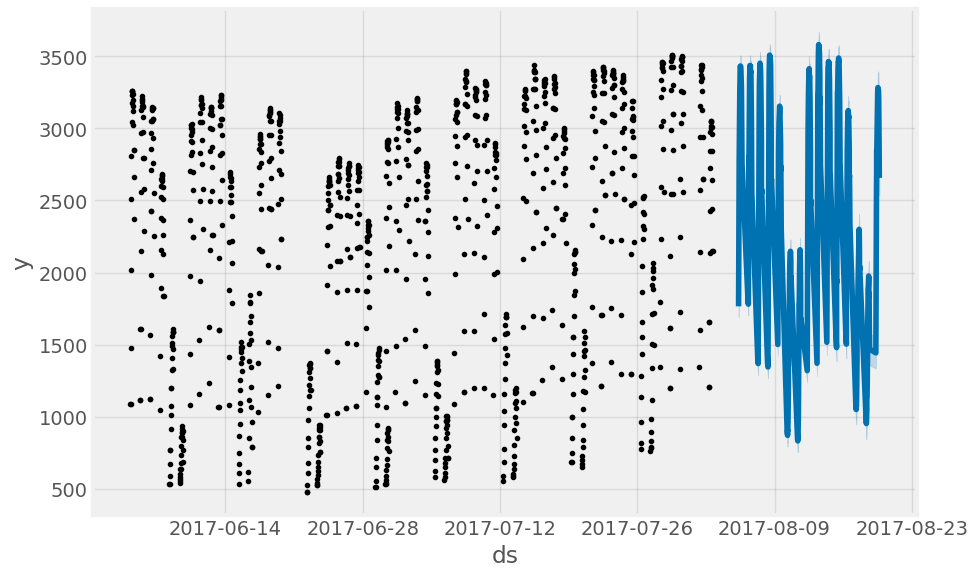

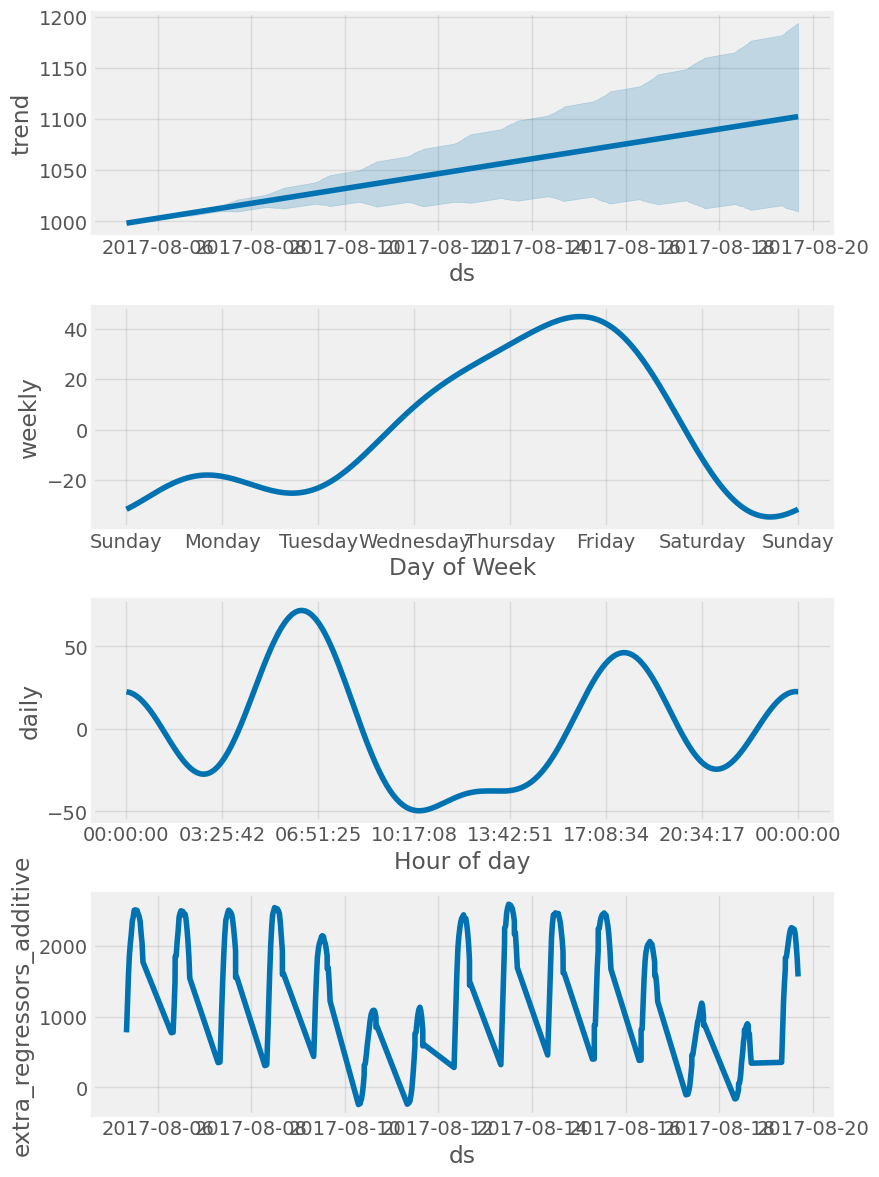

In [16]:
# predict
future = model.make_future_dataframe(periods=test.shape[0])
future = future.merge(test, on='ds', how='right')
forecast = model.predict(future)

# plot forecast
fig = model.plot(forecast)
plt.show()

# plot components
fig = model.plot_components(forecast)
plt.show()

In [17]:
# evaluate model
y_pred = forecast['yhat'].values
y_true = test['y'].values

print(f"Mean Absolute Error: {mean_absolute_error(y_true, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_true, y_pred)}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_true, y_pred))}")
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_true, y_pred)}")

Mean Absolute Error: 60.40682792393591
Mean Squared Error: 4866.1580078770985
Root Mean Squared Error: 69.75785266102375
Mean Absolute Percentage Error: 3.039729042804601


In [23]:
# feature importance
from prophet.utilities import regressor_coefficients
regressor_coef = regressor_coefficients(model)
regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')

,regressor,regressor_mode,coef
3,month,additive,-3.354684e+01
6,hour,additive,-4.547533e+00
4,dayOfWeek,additive,-2.543680e+00
10,dayOfYear,additive,-6.384768e-01
7,minute,additive,-2.378339e-03
1,date,additive,-7.389777e-15
2,year,additive,1.289804e-01
0,total_capacity,additive,2.489444e-01
8,second,additive,4.917017e-01
5,day,additive,2.712089e+00
